In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class VerticalStack(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, bias = False):
        super(VerticalStack, self).__init__()
        self.kernel_size = kernel_size
        self.pad = nn.ZeroPad2d(((kernel_size[1]-1)//2, (kernel_size[1]-1)//2, kernel_size[0]-1, 0))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1,bias = bias)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.bn(self.conv(self.pad(x)))
        return x

In [3]:
def shift_down(x):
    x = x[:,:,:-1,:]
    pad = nn.ZeroPad2d((0,0,1,0))
    x = pad(x)
    return x

In [4]:
class HorizontalStack(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1,bias = False):
        super(HorizontalStack, self).__init__()
        
        assert len(kernel_size) == 2, 'kernel should be tuple of size 2'
        
        self.kernel_size = kernel_size
        self.pad = nn.ZeroPad2d((kernel_size[1] - 1, 0, 0, 0))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1,bias = bias)
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.bn(self.conv(self.pad(x)))
        return x

In [5]:
def shift_right(x):
    x = x[:,:,:,:-1]
    pad = nn.ZeroPad2d((1,0,0,0))
    x = pad(x)
    return x

In [6]:
class BlockPixelCNN(nn.Module):
    def __init__(self,in_channels, kernel_size_v, kernel_size_h, stride = 1, bias = False):
        super(BlockPixelCNN, self).__init__()
        
        #assert out_channels % 2 == 0, 'out_channel has to be divisible by 2'
        self.vert = VerticalStack(in_channels, in_channels*2, kernel_size_v, stride = 1, bias = False)
        self.hor = HorizontalStack(in_channels, in_channels*2, kernel_size_h, stride = 1, bias = False)
        self.conv_v_h = nn.Conv2d(in_channels*2, in_channels*2, 1, 1, bias = False)
        self.bn1 = nn.BatchNorm2d(in_channels*2)
        self.conv1 = nn.Conv2d(in_channels, in_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        
        
    def forward(self, v, h):
        v_1, output = self.vertical(v)
        #print(shift_down(v).shape)
        h = self.horizontal(h, output) + h #+ shift_down(v) #experiment with residual
        return v_1, h
    
    def horizontal(self, x, x_vertical):
        x = (x_vertical) + self.hor(x)
        x = torch.sigmoid(x[:, 1::2, :,:]) * torch.tanh(x[:,0::2,:,:])
        x = self.conv1(x)
        x = self.bn2(x)
        return x
        
    def vertical(self, x):
        x = self.vert(x)
        output = self.conv_v_h(shift_down(x))
        output = self.bn1(output)
        x = torch.sigmoid(x[:,1::2,:,:]) * torch.tanh(x[:,0::2,:,:])
        return x, output

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self,input_channels, k_channels, v_channels, heads = 4, device = 'cuda'):
        super(AttentionBlock, self).__init__()
        
        self.input_channels = input_channels
        self.k_channels = k_channels
        self.v_channels = v_channels
        self.heads = heads
        
        self.conv_q = nn.Conv2d(input_channels, k_channels * heads, kernel_size = 1, stride = 1, bias = False)
        self.conv_k = nn.Conv2d(input_channels, k_channels * heads, kernel_size = 1, stride = 1, bias = False)
        self.conv_v = nn.Conv2d(input_channels, v_channels * heads, kernel_size = 1, stride = 1, bias = False)
        
        self.conv_h = nn.Conv2d(v_channels * heads, v_channels,  kernel_size = 1, stride = 1,bias = False)
        
        self.device = device
    def forward(self, x):
        '''
        x-> BCHW
        '''
        
        query = self.conv_q(x)
        key = self.conv_k(x)
        value = self.conv_v(x)
        
        query_shape = query.shape
        bs = query.size(0)
        
        query = query.view(bs, self.heads , query_shape[1]//self.heads , query_shape[2] * query_shape[3])#.reshape(bs, self.heads ,query_shape[1]//self.heads, -1)
        query = query.permute(0,1,3,2).view(query_shape[0] * self.heads, query_shape[2] * query_shape[3] , query_shape[1]//self.heads)
        
        key = key.view(bs, self.heads , query_shape[1]//self.heads , query_shape[2] * query_shape[3])#.reshape(bs, self.heads ,query_shape[1]//self.heads, -1)
        key = key.view(query_shape[0] * self.heads, query_shape[1]//self.heads , query_shape[2] * query_shape[3] )
        
        
        attn = torch.bmm(query, key)
        
        
        attn = attn / torch.sqrt(torch.FloatTensor([self.k_channels]).to(attn.device))
        
        mask = (torch.tril(torch.ones_like((attn)), diagonal = -1) * -100000).permute(0,2,1)
        #print(torch.where(attn > 0))
        
        #print(attn + mask)
        attn = attn + mask
        
        
        attn = F.softmax(attn, dim = -1)
        
        #plt.imshow(attn[0,:,:].detach())
        #plt.show()
        
        value_shape = value.shape
        value = value.view(value_shape[0] ,self.heads, value_shape[1]//self.heads, value_shape[2] * value_shape[3])
        value = value.permute(0,1,3,2).view(value_shape[0] * self.heads ,value_shape[2] * value_shape[3], value_shape[1]//self.heads)
        
        output = torch.bmm(attn, value)
        
        #print(output.shape)
        
        output = output.view(value_shape[0], self.heads, value_shape[2] * value_shape[3] , self.v_channels).contiguous()

        output = output.permute(0,1,3,2).contiguous().view(value_shape[0], self.heads * self.v_channels, value_shape[2] , value_shape[3]).contiguous()
        
        output = self.conv_h(output)
        #output = output.reshape(value_shape[0], -1, value_shape[2], value_shape[3])
        return output

In [8]:
class PixelSNAILBlock(nn.Module):
    def __init__(self, in_channels,aux_channels, k_size, v_size):
        super(PixelSNAILBlock, self).__init__()
        self.cnn_block = nn.ModuleList([BlockPixelCNN(in_channels, (2,3), (1,3)) for i in range(4)])
        self.attn_block = AttentionBlock(in_channels+aux_channels, k_size, v_size)
        
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(v_size, in_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(in_channels)
        
    def forward(self, resblock_v,resblock_h, main_input):
        
        for i in range(len(self.cnn_block)):
            resblock_v, resblock_h = self.cnn_block[i](resblock_v, resblock_h)
        
        attn = torch.cat((resblock_h, shift_down(main_input)), dim = 1)
        attn = self.attn_block(attn)
        
        resblock_h = F.elu(self.bn1(self.conv1(F.elu(resblock_h))))
        #print(resblock_h)
        attn = F.elu(self.bn2(self.conv2(F.elu(attn))))
        
        resblock_h = resblock_h + attn
        resblock_h = F.elu(self.bn3(self.conv3(F.elu(resblock_h))))
        
        return resblock_v, resblock_h

In [9]:
class PixelSNAIL(nn.Module):
    def __init__(self, in_channels, out_channels, k_size , v_size , mixtures = 10, m_blocks = 4):
        super(PixelSNAIL, self).__init__()
        self.vert = VerticalStack(in_channels,out_channels,(2,3))
        self.hor = HorizontalStack(in_channels,out_channels,(1,3))
        self.model = nn.ModuleList([PixelSNAILBlock(out_channels, in_channels, k_size , v_size) for i in range(m_blocks)])
        
        #self.conv1 = nn.Conv2d(out_channels, mixtures * 3, kernel_size = 1, stride = 1)
        self.conv1 = nn.Conv2d(out_channels, 1, kernel_size = 1, stride = 1, bias = False)
    def forward(self, inputs):
        vert = self.vert(inputs)
        hor = shift_right(self.hor(inputs))
        
        for i in range(len(self.model)):
            vert, hor = self.model[i](vert, hor, inputs)
            
        hor = self.conv1(F.elu(hor))
        return hor

In [10]:
#implementing for unnormalized
def discretized_logistic_loss_1d(outputs, inputs, d =  255):
    '''
    outputs -> BDHW, where D is n_mixs * 3
    inputs -> BCHW
    d -> maximum support of the distribution
    '''
    
    inputs = inputs.permute(0,2,3,1).contiguous()
    outputs = outputs.permute(0,2,3,1).contiguous()
    
    input_shape = inputs.shape
    n_mixs = int(outputs.shape[-1]/3)
    
    inv_scales = torch.exp(-outputs[:,:,:,n_mixs*2:n_mixs*3])
    means = outputs[:,:,:,n_mixs*1:n_mixs*2]
    logits = outputs[:,:,:,:n_mixs]
    plus_in = inv_scales * (inputs + 0.5 - means)
    min_in = inv_scales * (inputs - 0.5 - means)
    
    cdf_delta = plus_in - min_in
    log_cdf_delta = torch.log(torch.clamp(cdf_delta, min = 1e-12))
    
    log_cdf_max = torch.log(torch.clamp(1-torch.sigmoid(inv_scales * (d - 1.5 - means)), min = 1e-12))
    
    log_cdf_min = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)), min = 1e-12))
    
    inputs_log_probs = torch.where(inputs<0.001, log_cdf_min, torch.where(inputs > d -1 - 1e-3,
                                                               log_cdf_max, log_cdf_delta))
    
    pi_log_probs = F.log_softmax(logits, dim = -1)
    log_probs = inputs_log_probs + pi_log_probs
    
    return torch.logsumexp(log_probs, dim = -1)

In [11]:
model = PixelSNAIL(1,256, 16, 128, m_blocks =20)

tensor([[0.]], grad_fn=<SelectBackward>)


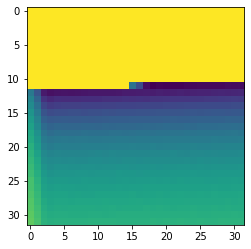

In [12]:
model.eval()
inputs = torch.zeros(1,1,32,32)

inputs[:,:,10,15] = 1

output = model(inputs)
print(output[:,:,10,15])

plt.imshow(output.squeeze(0).detach().permute(1,2,0)[:,:,:3].numpy())


In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#print(testset[0][0] * 255)


C:\Users\johna\anaconda4\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


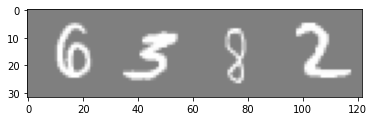

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [16]:
net = PixelSNAIL(1,256, 16, 128, m_blocks =1).to(device = 'cuda')
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_fn  = nn.BCELoss().cuda()

In [17]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = net(inputs)
        # print statistics
        #print(outputs)
        #print(inputs)
        loss = F.mse_loss(outputs, inputs)
        print(loss)
        #print(loss.shape)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
net.eval()
for i, data in enumerate(testloader):
    with torch.no_grad():
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        output = net(inputs)
        imshow(torchvision.utils.make_grid(inputs.detach().cpu()))
        imshow(torchvision.utils.make_grid(output.detach().cpu()))